In [75]:
import numpy as np
import sys
import os
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, ipysliderule, io, earthdata
import warnings
from IPython import display
import json
import utils.toolshelf as t
#import LagrangianDEMdifferencing.utils.lagrange as lagrange
from random import sample

import fiona

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
### Feb 21 2024 ####

In [70]:
####################### SET PARAMETERS #################

In [77]:
# # Select predetermined track (2 digit cycle number)
shelf = "cook"
site = "cook_east"
cycle = '19'

# Data access options
# (-1: Skip altogether, 0: force process fresh, 1: load from geojson (process otherwise), 2: load from csv)
accessType = 0

#input options
# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 10.0
cnf = 2

#output options
# Save flag 06 (0: dont save, 1: save as geojson (slow but everything works), 
# 2: save as csv (faster but nothing works))
sFlag06 = 1

# Save flag melange (0: dont save, 1: save)
sFlagm = 0

# Save flag 03 (0: dont save, 1: save as geojson)
sFlag03 = 0

# File locations
shpPath = f"../shapes/{shelf}/{site}_{cycle}.geojson"
if not os.path.isfile(shpPath): shpPath = f"../shapes/{shelf}/{site}_00.geojson"
#shpPath = f"../shapes/{site}_2019-09-03_04.geojson"
#shpPath = f"../shapes/{site}.geojson"

datPath = f"../data/"
figPath = f"../figs/{site}/"
filename03 = f"{datPath}{site}_ATL03_cyc{cycle}_res{int(res)}"
filename06 = f"{datPath}{site}_ATL06_cyc{cycle}_res{int(res)}"
filename06Load = f"{datPath}{site}_res{int(res)}/{site}_ATL06_cyc{cycle}_res{int(res)}"
filenameMel = f"{datPath}{site}/{site}_mel_cyc{cycle}_res{int(res)}"

In [78]:
shpPath

'../shapes/cook/cook_east_00.geojson'

In [79]:
########################### BEGIN ####################

In [80]:
# Configure ICESat-2 API
# an int iterable error might just mean it doesn't want to initialize twice
icesat2.init(url="slideruleearth.io")

TypeError: 'int' object is not callable

In [183]:
# gt dictionary
global gtDict, revgtDict, geoidDefault
gtDict = {"gt1l": 10, "gt1r": 20, "gt2l": 30, "gt2r": 40, "gt3l": 50, "gt3r": 60, 10: "gt1l", 20: "gt1r", 30: "gt2l", 40: "gt2r", 50: "gt3l", 60: "gt3r"}
geoidDefaultDict = {'ross1': -55.5, 'filchnerF1': -14.45734}
try: geoidDefault = geoidDefaultDict[site]
except: 
    print('no geoid default set')
melangeCutoffDict = {'ross1': 30, 'filchnerF1': 60, 'larsenC': 20, 'ninnis': 10, 'cook_east': 30}
min_photonDict = {'ross1': 200, 'filchnerF1': 200, 'larsenC': 200}

'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    #global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    granID = gid[:]
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = int(f'{gid[2][6:8]}')
    version = int(f'{gid[3]}')
    release = int(f'{gid[4][0:2]}')
    return {"shortName": shortName, "date": dat, "time": tim, 
            "rgt": rgt, "cycle": cycle, "granuleNumber": granuleNumber, 
            "version": version, "release": release, "granuleID": granID}

# Get a datetime formatted for earthdata cmr search from geodataframe timestamp
def getDateTime(timestp):
    dat, tim = timestp.date(), timestp.time().strftime("%H:%M:%S")
    return f"{dat}T{tim}Z"

def displayInfo(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    print("Beams: {}".format([revgtDict[b] for b in list(gdf['gt'].unique())]))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    print(f"Vertical range {gdf.h_mean.min()}m to {gdf.h_mean.max()}m")
    return

def display03Info(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    #print("Beams: {}".format([revgtDict[b] for b in list(atl06_sr['gt'].unique())]))
    print("Spots: {}".format(gdf["spot"].unique()))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    return

def getTrackList(gdf, min_photons=200, print_lens=False, verbose=True):
    rgtAll = atl06_sr["rgt"].unique()
    gtAll = atl06_sr['gt'].unique()
    cycleAll = atl06_sr["cycle"].unique()
    lens = []
    tracks=[]

    for cyc in cycleAll:
        #t = atl06_sr[atl06_sr.cycle==cyc]
        for r in rgtAll:
            #t = t[t.rgt==r]
            for g in gtAll:
                t = atl06_sr[(atl06_sr.cycle==cyc)*(atl06_sr.rgt==r)*(atl06_sr.loc[:, 'gt']==g)]
                if len(t)>min_photons:
                    tracks.append((cyc, r, revgtDict[g]))
                    lens.append(len(t))
    if print_lens: print(lens)
    if verbose:
        print(f'Finding tracks with minimum of {min_photons} photons')
        print(f'{len(lens)} found')
    return tracks

def getTrack(dat, trackInfo):
    cycle, rgt, gt = trackInfo[0], trackInfo[1], gtDict[trackInfo[2]]
    track = dat[(dat.rgt==rgt)*(dat.cycle==cycle)*(dat.loc[:, 'gt']==gt)]
    return track, cycle, rgt, gt

def geoCorrect(dat):
    # Geo correct atl03 data
    return dat['height']-dat['geoid']

# Plotting stuff
def plot06(track, save=False, titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xl=None, yl=None):
    try:
        fig, ax = plt.subplots(figsize=[15, 3])

        x = (track['distance']-track['distance'][0])/1000
        x = track.geometry.y
        y = track.h_mean
        if not isSeaward:
            print("Track should be reversed to seaward orientation")
            #x = (track['distance']-(track['distance'][-1]))/1000
        ax.plot(x, y, '-', color='orange', linewidth=2.5, label='ATL06-SR')

        x = (mTrack['distance']-track['distance'][0])/1000
        x = mTrack.geometry.y
        y = mTrack.h_mean
        ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
        ax.set_title(titl)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_ylim(yl)
        ax.set_xlim(xl)
        ax.legend(loc=4, frameon=False)
        info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
        plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
                 transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
        if save:
            plt.savefig(f'{figPath}melange/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_mel.png', 
                        dpi=150, bbox_inches='tight')
            
    except: print(f"something went wrong with this track")
    
#Save elevations
def saveMelange(dat):
    datReduced = dat.loc[:, ['cycle', 'rgt', 'spot', 'h_mean', 'geometry']]
    datReduced.to_file(f"{filenameMel}.geojson", driver='GeoJSON')
    return



no geoid default set


In [96]:
# Read in EPSG:3031 shapefile and convert to EPSG:4326
shpFile = gpd.read_file(shpPath)
shpFile.crs = 'EPSG:3031'
target_epsg = 'EPSG:4326'
shpDF = shpFile.to_crs(target_epsg)
region = sliderule.toregion(shpDF)["poly"]
#transformed_gdf.to_file(f"test.geojson", driver='GeoJSON') 

In [97]:
shpDF

,NAME,Regions,TYPE,geometry
0,Cook,East,FL,"MULTIPOLYGON (((153.68915 -68.37871, 153.69455..."


In [98]:
list(shpDF.geometry.iloc[0].geoms)

[<POLYGON ((153.689 -68.379, 153.695 -68.385, 153.687 -68.407, 153.694 -68.42...>]

In [99]:
parms = {
    "poly": region,
    "srt": 0,
    "len": res*2,
    "res": res,
    "cnf": cnf,
    "maxi": 6,
    "ats": 5.0,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": cycle,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"]
}

In [86]:
%%time
if accessType == 0:
    print('Processing new ATL06-SR dataset')

    # Request ATL06 Data
    print('Downloading all available data')
    atl06_sr = icesat2.atl06p(parms)
    atl06_sr = atl06_sr[(atl06_sr.spot==2)+(atl06_sr.spot==4)+(atl06_sr.spot==6)]

    # Display Statistics
    displayInfo(atl06_sr)
    insufficientDataCache=[]

    # Save all data
    if sFlag06==1:
        # save geodataframe as geojson
        print(f'Saving file as geojson named {filename06}.geojson')
        atl06_sr.to_file(f"{filename06}.geojson", driver='GeoJSON')
    elif sFlag06==2:
        # Save geodataframe as csv
        print(f'Saving file as csv named {filename06}.csv')
        atl06_sr.to_csv(f"{filename06}.csv")

elif accessType==1:
    #load from geojson
    print('Downloading atl06-SR data upload from .geojson file')
    atl06_sr = gpd.read_file(f"{filename06Load}.geojson").set_index('time')
    displayInfo(atl06_sr)
elif accessType==2:
    # Load from csv (everything is a string)
    print('Downloading atl06-SR data upload from .csv file')
    atl06_sr = gpd.read_file(f"{filename06Load}.csv").set_index('time')
    displayInfo(atl06_sr)
elif accessType==-1:
    print('skipping data download altogether')

Processing new ATL06-SR dataset
Reference Ground Tracks: [  47  253  314  367  375  428  436  489  550  817  870  878  931  992
 1198 1259 1312 1320 1381]
Beams: ['gt3r', 'gt2r', 'gt1r']
Cycles: [19]
Received 150782 elevations
Across 60 strong tracks
Date range 2023-03-24 to 2023-06-19
Vertical range -305.2247677502439m to 507.77749769859616m
Saving file as geojson named ../data/cook_east_ATL06_cyc19_res10.geojson
CPU times: user 59.1 s, sys: 1.65 s, total: 1min
Wall time: 10min 35s


In [184]:
#Triple check this cell

geoidDefault = np.mean(atl06_sr.geoid)

# separate all good tracks and put them into a list
trackList = getTrackList(atl06_sr, print_lens=True, min_photons=100)#, min_photons=min_photonDict[site])
ss_atl06_sr = pd.concat([getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])

#Geoid and outliers
# for ross limits good limits are
print('correcting for geoid, scraping outliers')
print(f'Geoid height: {geoidDefault} m')
ss_atl06_sr.h_mean -= geoidDefault
# filchner1 -5, 100
ss_atl06_sr = ss_atl06_sr[(ss_atl06_sr.h_mean<150)*(ss_atl06_sr.h_mean>-5)]

try: melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
except: print('Cannot find melange, no cutoff set')
ss_atl06_sr_list = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
displayInfo(ss_atl06_sr)


if sFlagm==1: saveMelange(melange_sr)

[696, 806, 1100, 3763, 3201, 4857, 4686, 4511, 3870, 4229, 4224, 2296, 1971, 1635, 4623, 4783, 4943, 1495, 1744, 1684, 5374, 5211, 5045, 4960, 4762, 4837, 2871, 2509, 2373, 1873, 1407, 1411, 401, 4999, 5249, 5499, 1602, 1358, 1106, 5211, 4938, 4406, 4343, 4045, 3725]
Finding tracks with minimum of 100 photons
45 found
correcting for geoid, scraping outliers
Geoid height: -54.24571189482687 m
Reference Ground Tracks: [  47  367  375  428  436  489  550  817  870  878  931  992 1198 1259
 1312 1320]
Beams: ['gt3r', 'gt2r', 'gt1r']
Cycles: [19]
Received 145338 elevations
Across 51 strong tracks
Date range 2023-03-24 to 2023-06-15
Vertical range -4.535491326386598m to 149.99690482234087m


In [274]:
# Plot every 40 points from tracklist to not slow down the notebook
projection = 'South'
max_plot_points = atl06_sr.shape[0]
m = ipysliderule.leaflet(projection, zoom=10, scroll_wheel_zoom=True)
m.GeoData(ss_atl06_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
#m.GeoData(
display.display(m.map)

Deprecated. Will be removed in a future release


Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [101]:
# Plot every 40 points from tracklist to not slow down the notebook
projection = 'South'
max_plot_points = atl06_sr.shape[0]
cpoint = atl06_sr.iloc[1000].geometry
m = ipysliderule.leaflet(projection, center=[cpoint.x, cpoint.y], zoom=10, scroll_wheel_zoom=True)
m.GeoData(melange_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
display.display(m.map)

Deprecated. Will be removed in a future release


Map(center=[152.06005889680114, -68.64514168212666], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [29]:
ss_atl06_sr.h_mean.max()

89.53870887400568

0, (19, 47, 'gt3r')
something went wrong with this track
1, (19, 47, 'gt2r')
something went wrong with this track
2, (19, 47, 'gt1r')
something went wrong with this track
3, (19, 367, 'gt3r')
something went wrong with this track
4, (19, 367, 'gt2r')
something went wrong with this track
5, (19, 375, 'gt3r')
something went wrong with this track
6, (19, 375, 'gt2r')
something went wrong with this track
7, (19, 375, 'gt1r')
something went wrong with this track
8, (19, 428, 'gt3r')
something went wrong with this track
9, (19, 428, 'gt2r')
something went wrong with this track
10, (19, 428, 'gt1r')
something went wrong with this track
11, (19, 436, 'gt3r')
something went wrong with this track
12, (19, 436, 'gt2r')
something went wrong with this track
13, (19, 436, 'gt1r')
something went wrong with this track
14, (19, 489, 'gt3r')
something went wrong with this track
15, (19, 489, 'gt2r')
something went wrong with this track
16, (19, 489, 'gt1r')
something went wrong with this track
17, (19, 5

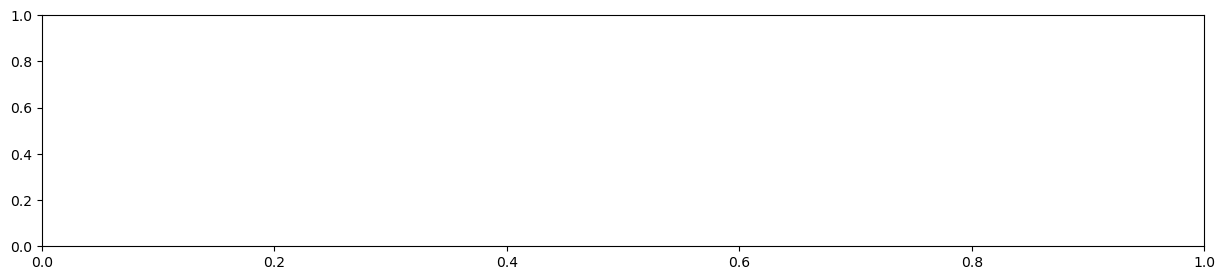

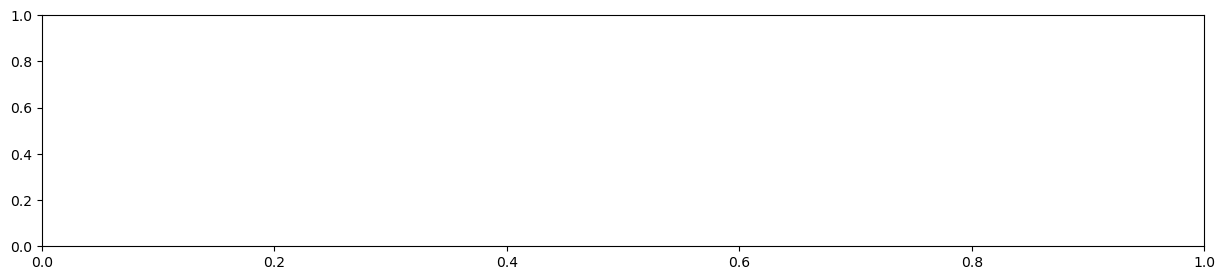

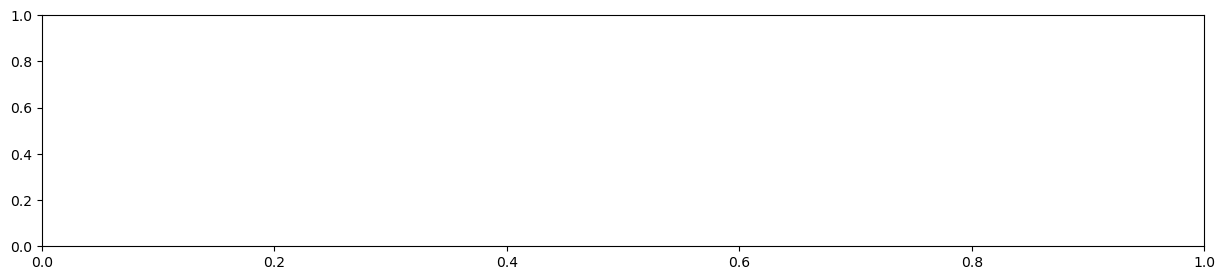

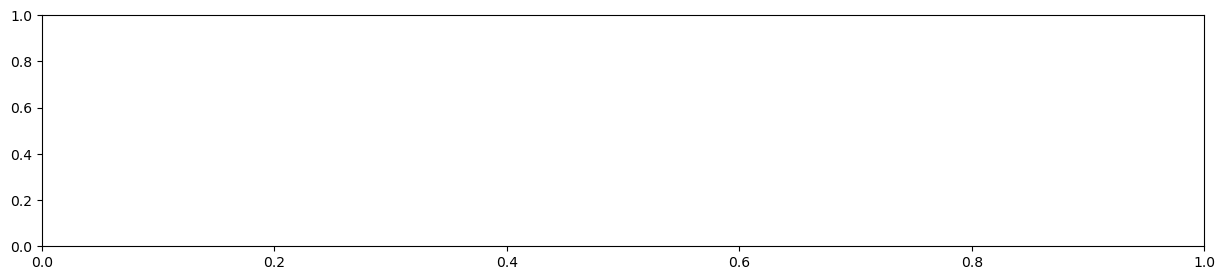

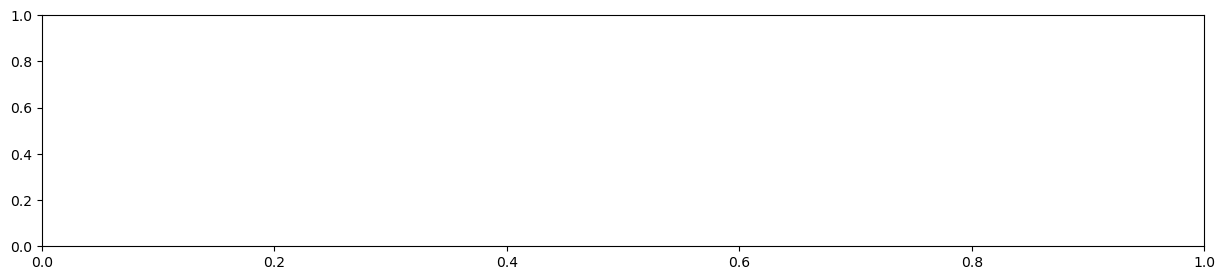

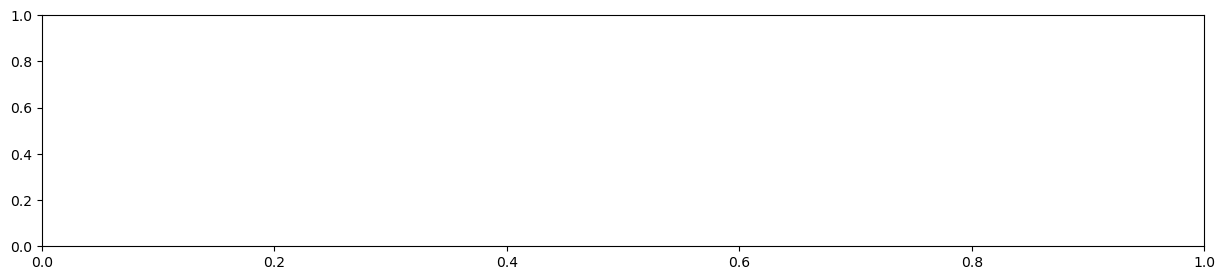

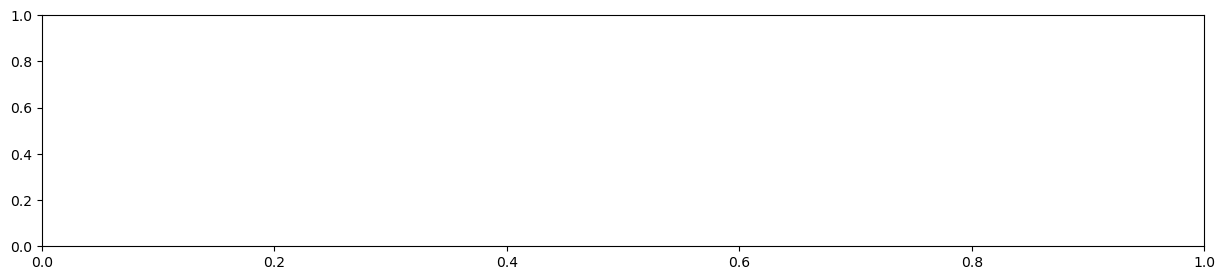

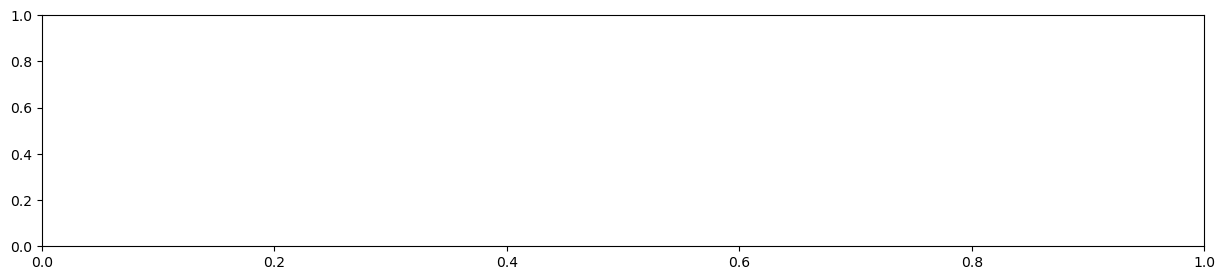

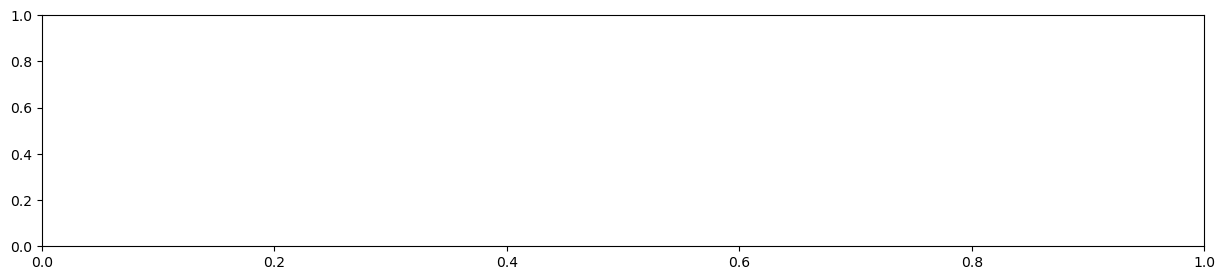

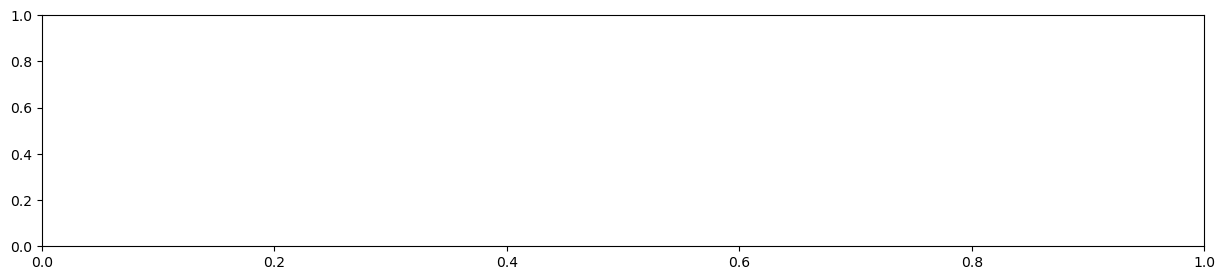

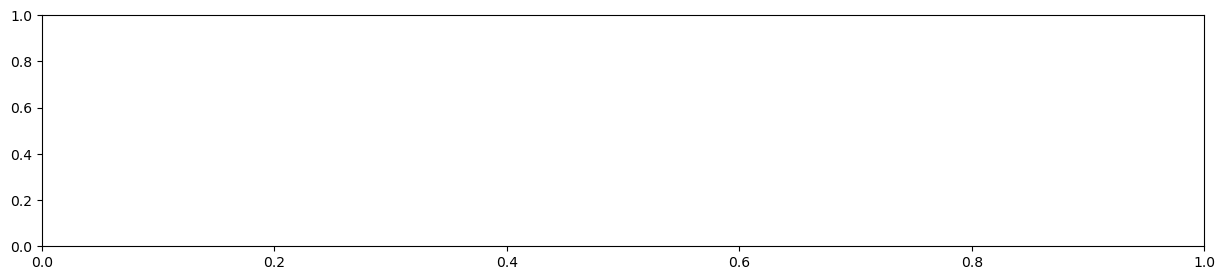

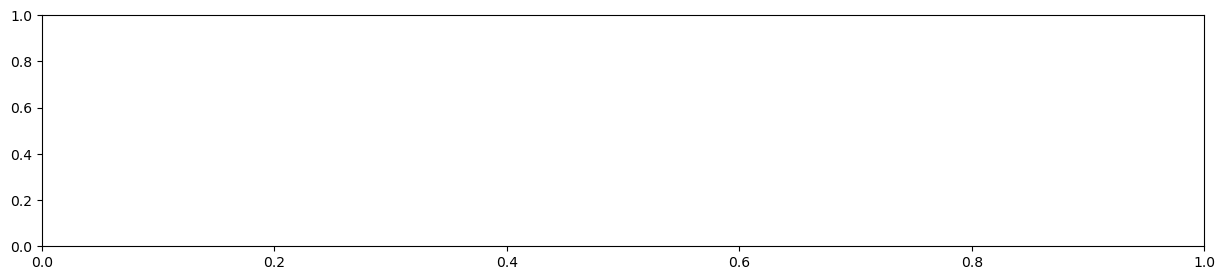

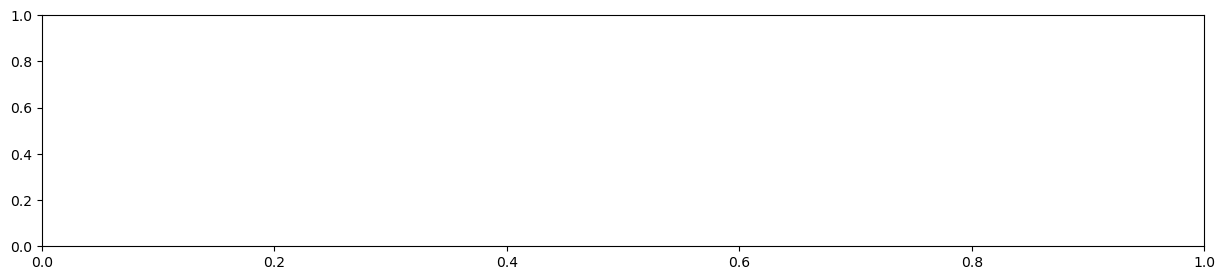

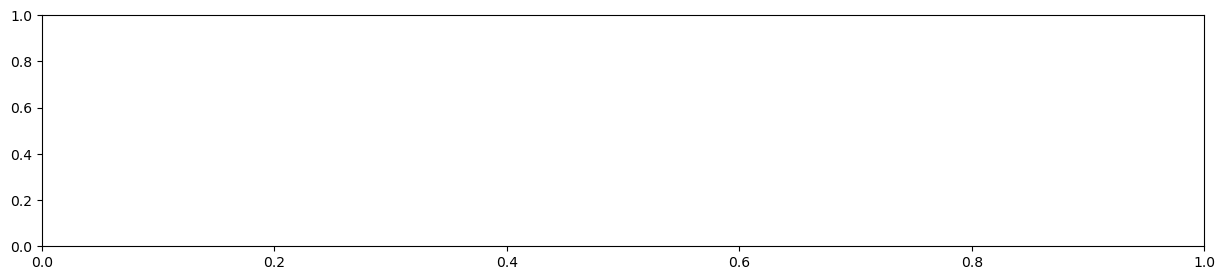

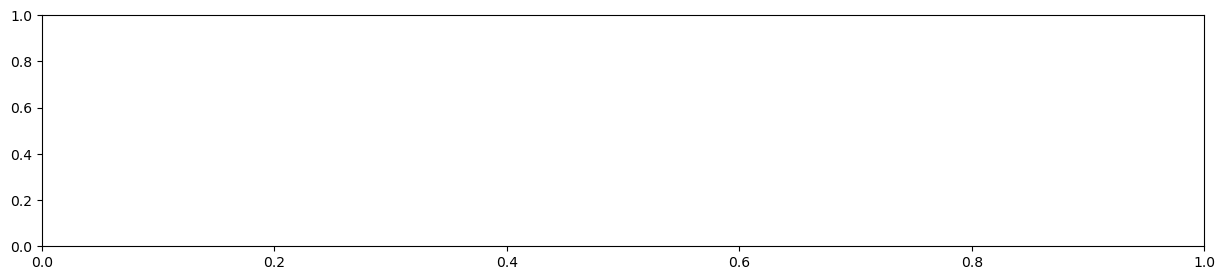

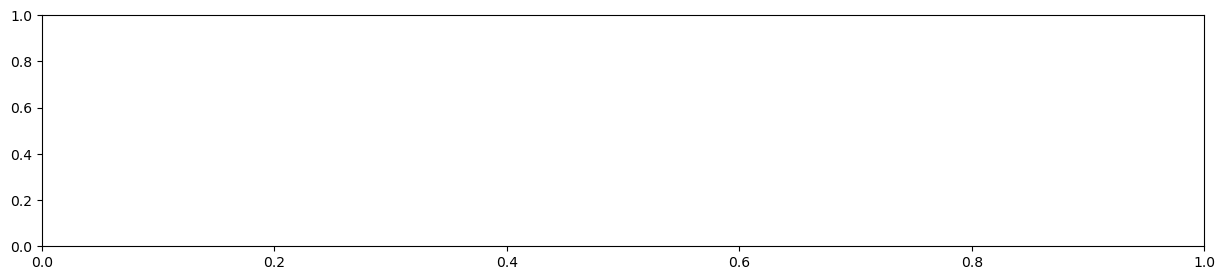

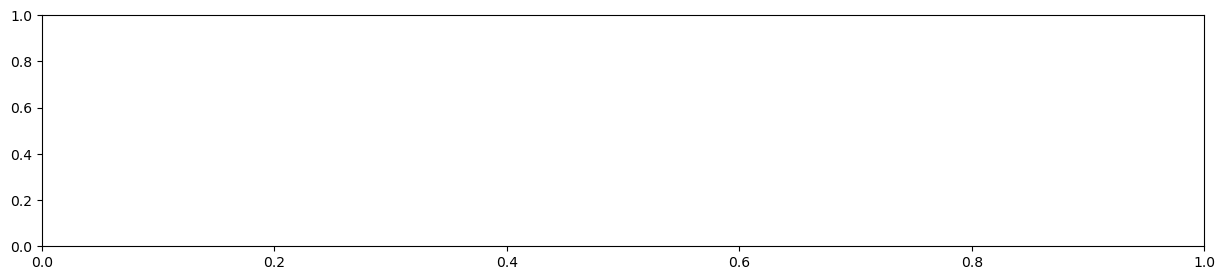

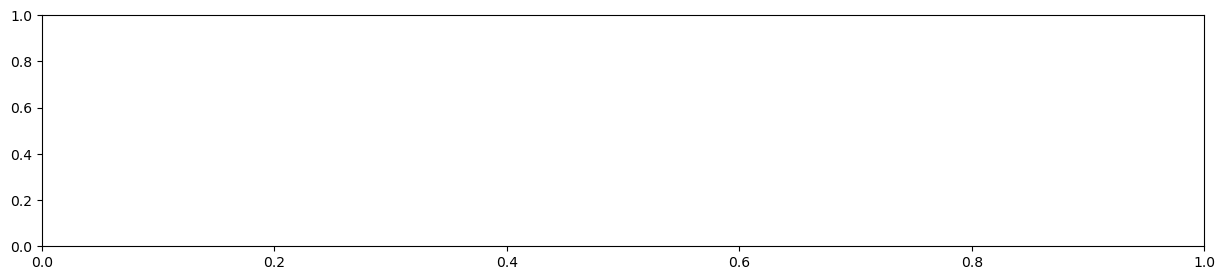

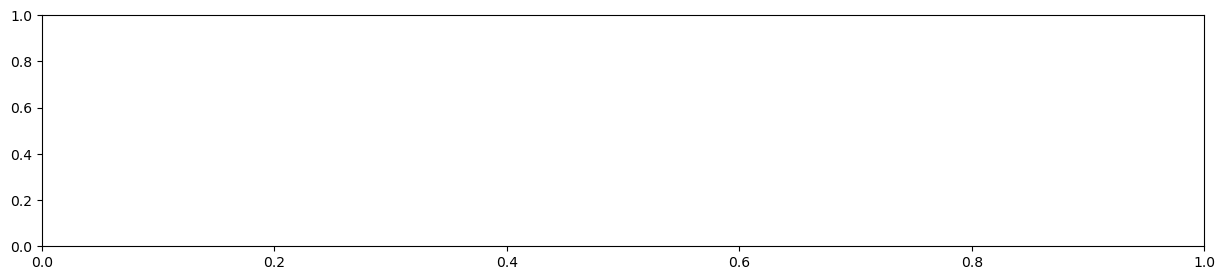

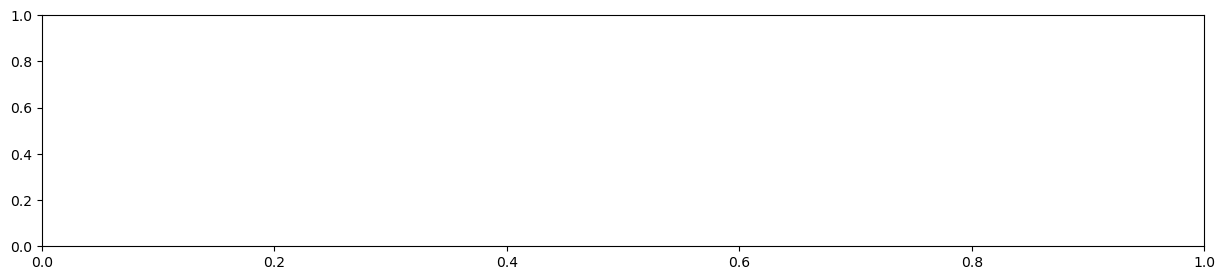

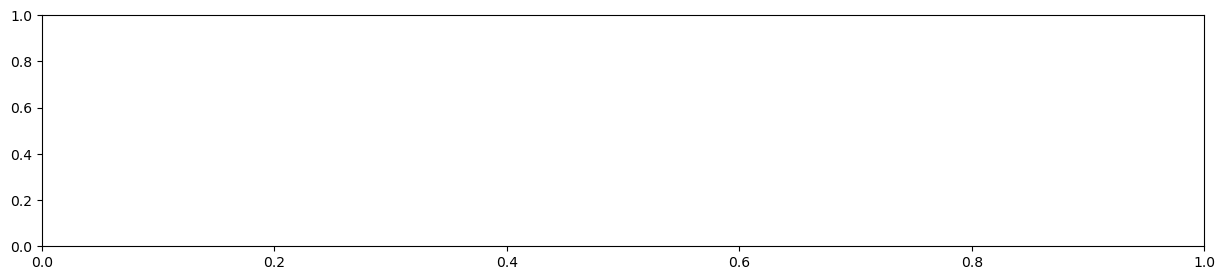

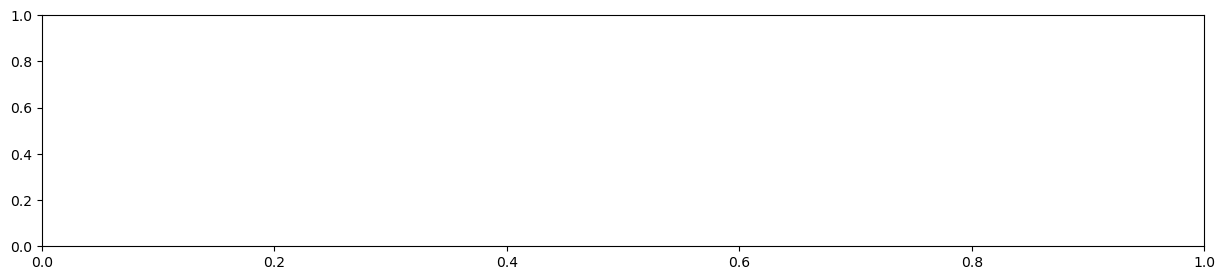

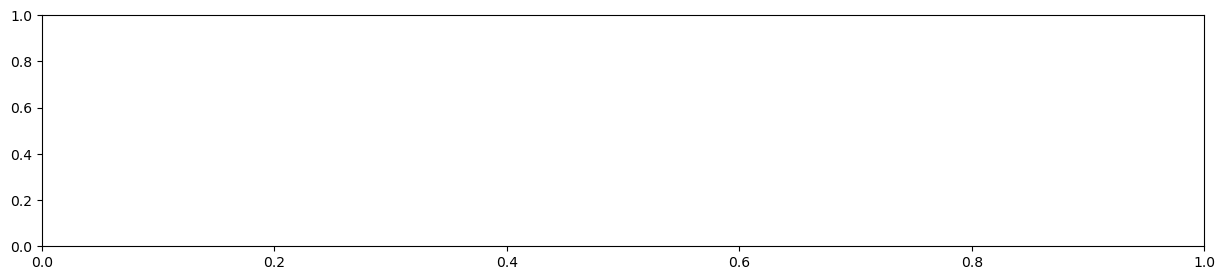

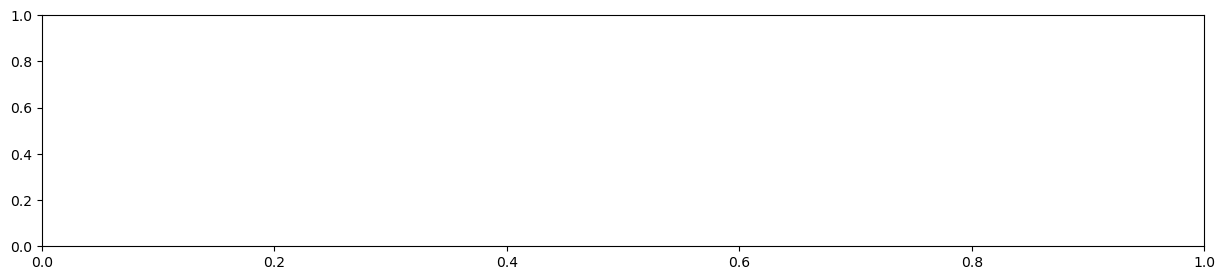

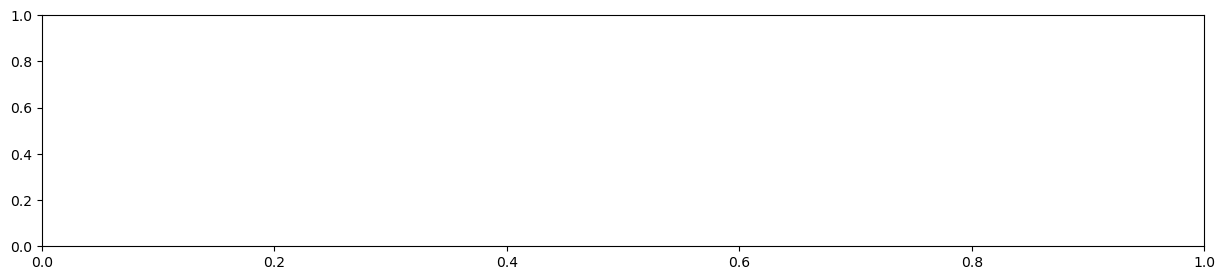

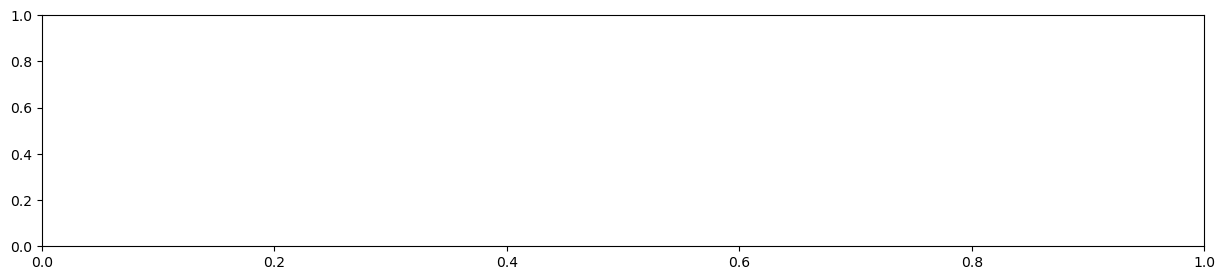

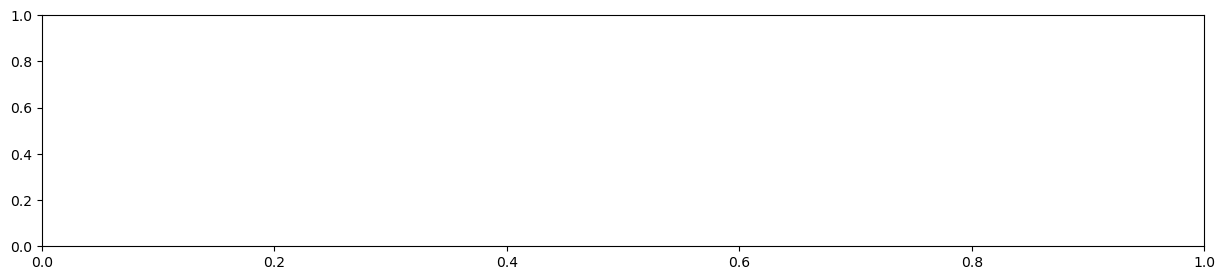

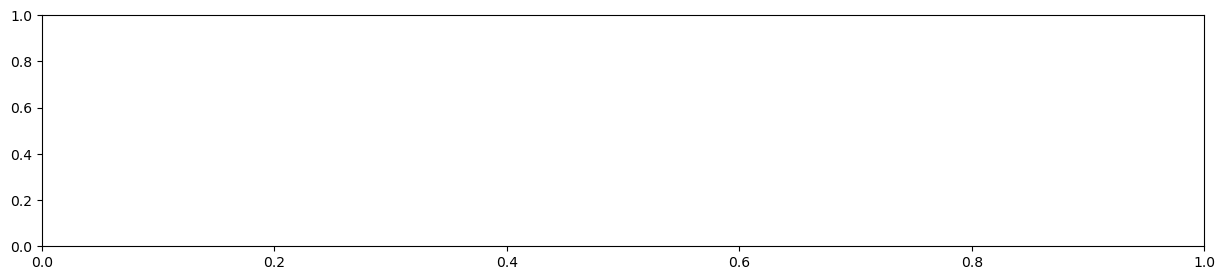

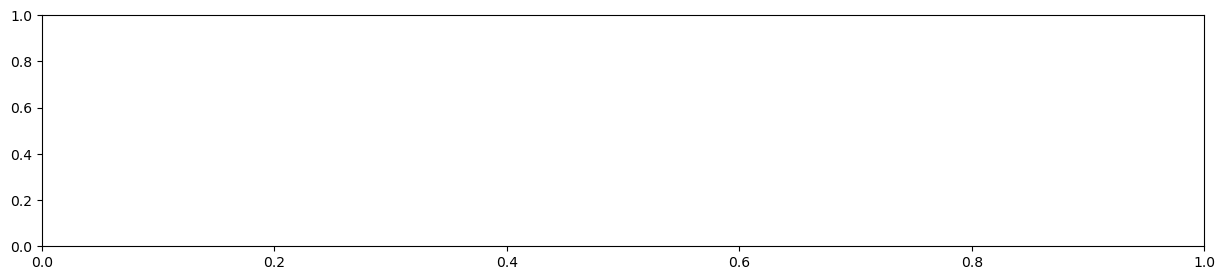

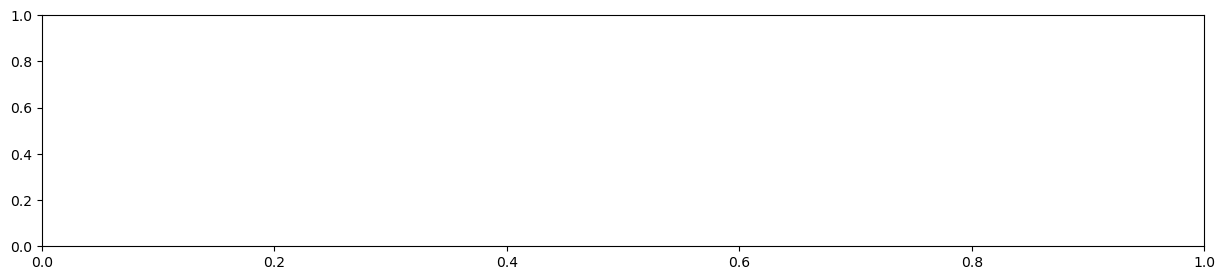

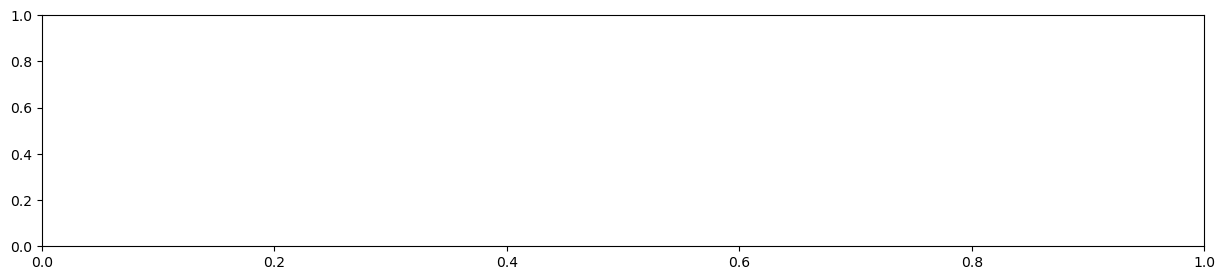

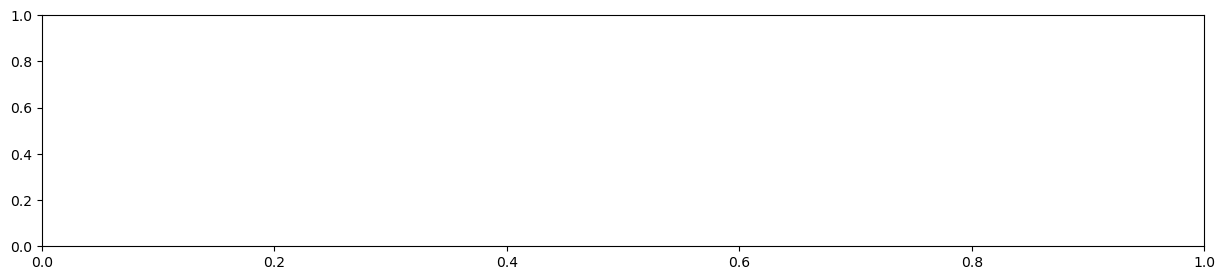

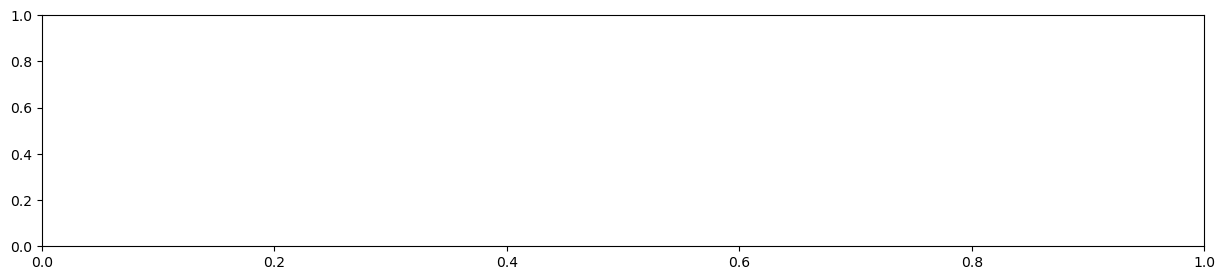

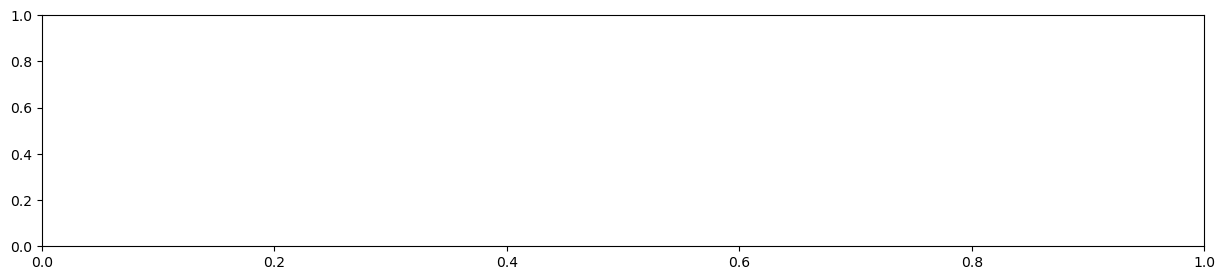

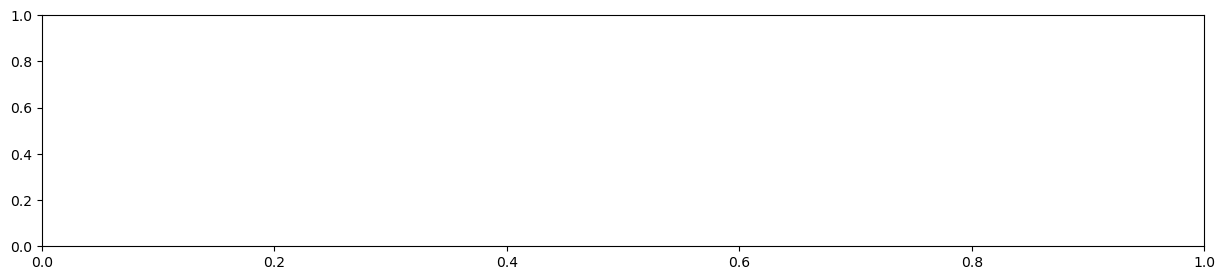

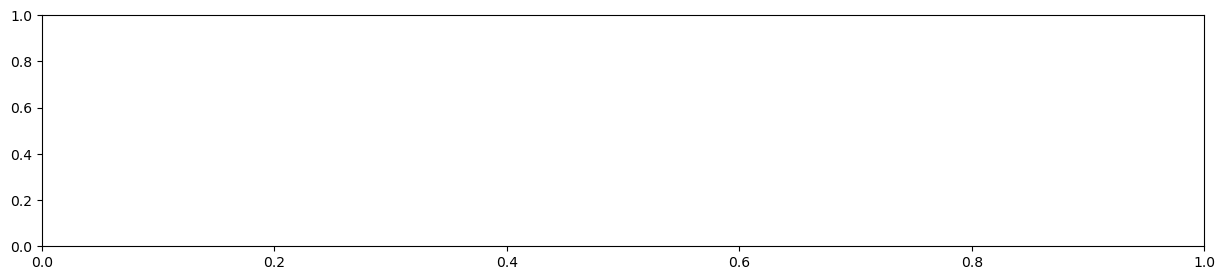

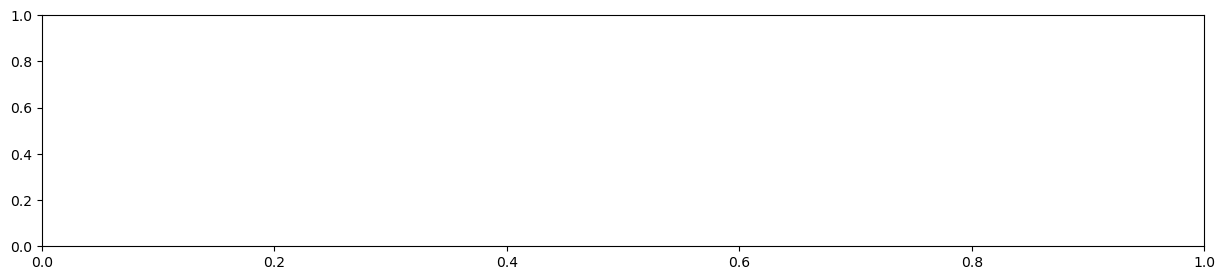

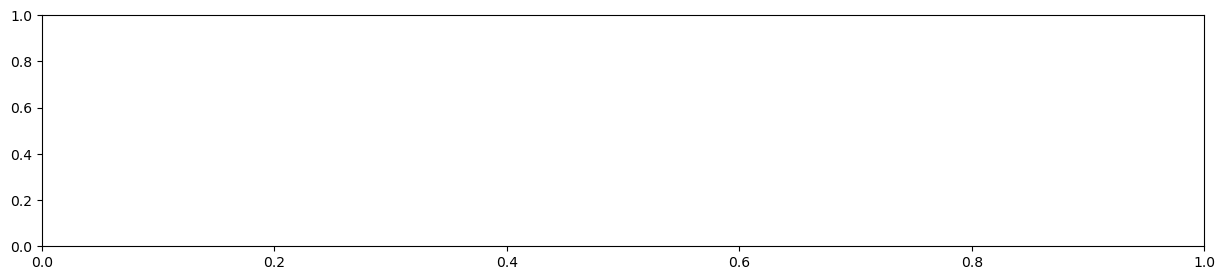

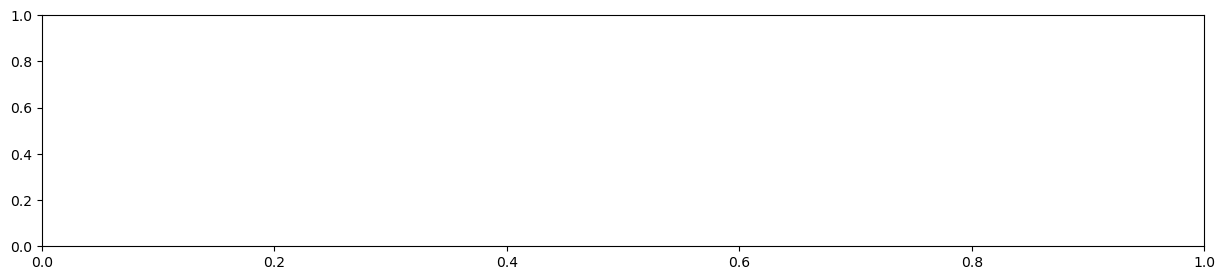

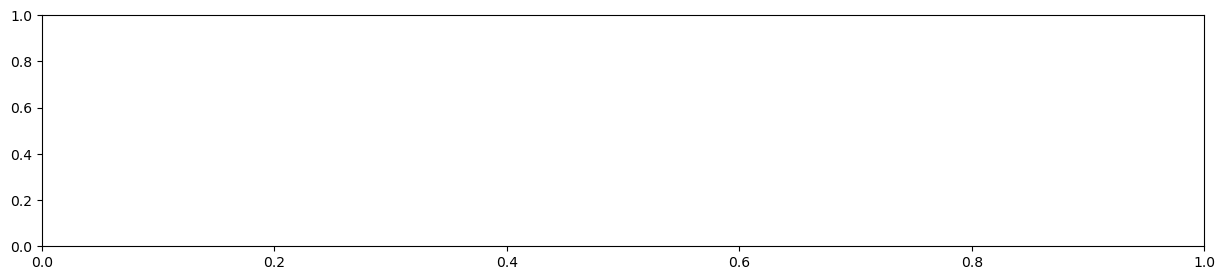

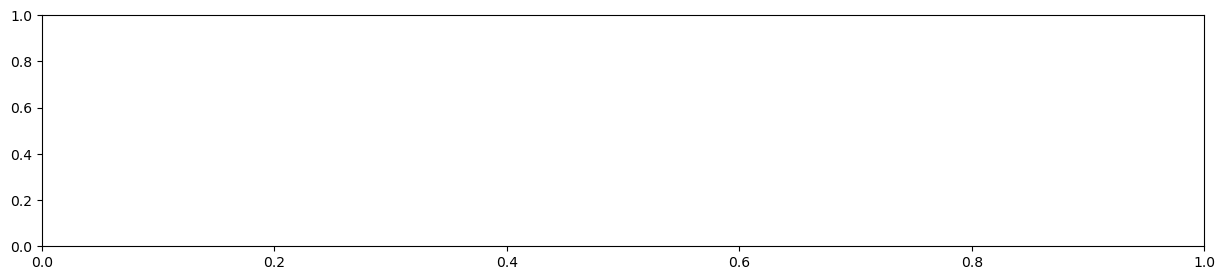

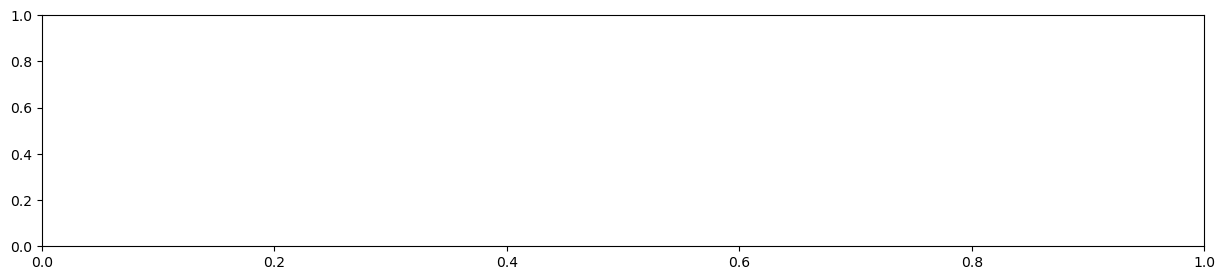

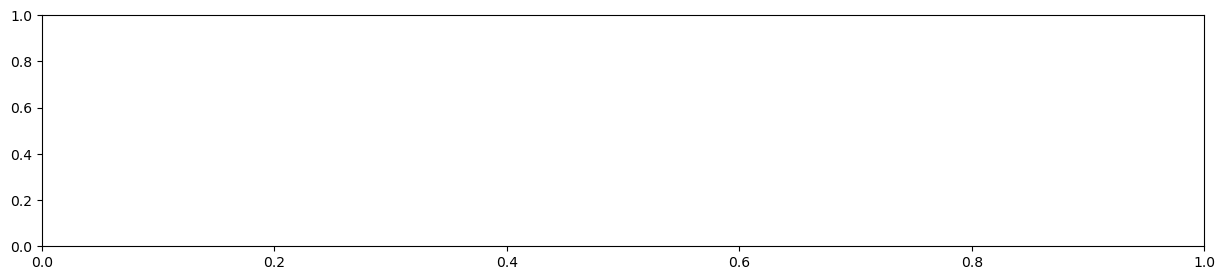

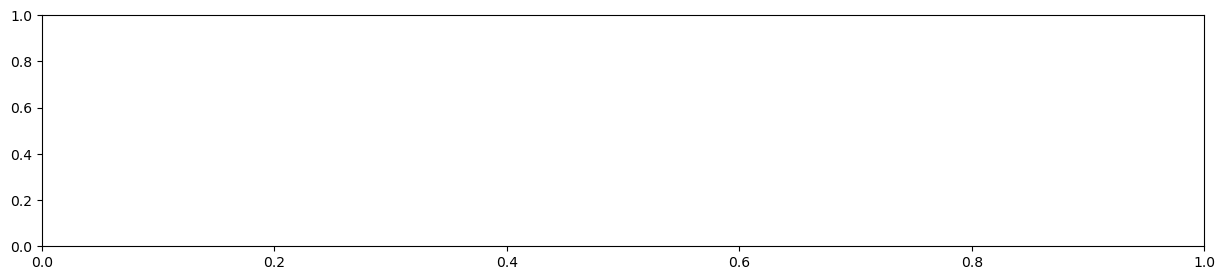

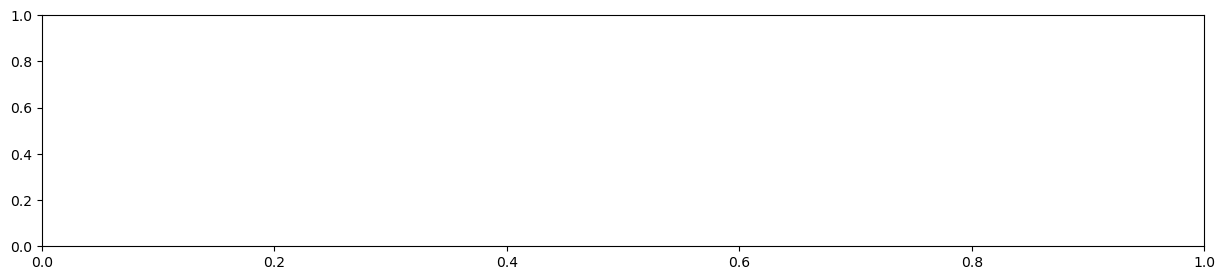

In [107]:
# Plot method (0: random track, 1: everything)
plotMethod = 1

# plot settings
yl = None#[0, 92]
xl=None

if plotMethod==0:
    trackInfo = sample(trackList, 1)[0]
    track, cycle, rgt, gt = getTrack(ss_atl06_sr, trackInfo)
    mTrack, cycle, rgt, gt = getTrack(melange_sr, trackInfo)

    try: 
        isSeaward = track.geometry.y.iloc[0]< track.geometry.y.iloc[10]
        dat = track.index.min().date()
        print(f"Randomly selected track: Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {revgtDict[gt]}")
        print(f"Contains {len(track)} photons")
    except: 
        print(f"Exception: Random track Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {revgtDict[gt]} does not contain enough data")
        if rgt not in insufficientDataCache: insufficientDataCache.append([rgt, revgtDict[gt]])
        print(f"Insufficient data cache: {insufficientDataCache}")
        
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    plot06(track, save=False, titl=titl, xlab=xlab, ylab=ylab, yl=yl)
    
elif plotMethod==1:
    count=0
    
    for t in trackList:
        print(f"{count}, {t}")
        count+=1
        
        track, cycle, rgt, gt = getTrack(ss_atl06_sr, t)
        mTrack, cycle, rgt, gt = getTrack(melange_sr, t)
        dat = track.index.min().date()
        
        
        titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
        xlab = 'S-N latitude'
        ylab = 'Elevation above geoid (m)'
        plot06(track, save=True, titl=titl, xlab=xlab, ylab=ylab, yl=yl)
        #plt.axhline(y=60)

In [156]:
gtDict['gt3r']

60

In [185]:
rgt, gt = 817, 60
trackInfo = (cycle, rgt, gtDict[gt])
track, cycle, rgt, gt = getTrack(ss_atl06_sr, trackInfo)
mTrack, cycle, rgt, gt = getTrack(melange_sr, trackInfo)

In [186]:
%%time
#EarthData query to acquire granule IDs

earthdata.set_max_resources=2000
granules_list = earthdata.cmr(short_name='ATL03', polygon=region, version='006', time_start=getDateTime(atl06_sr.index.min()), 
    time_end=getDateTime(atl06_sr.index.max()), return_metadata=True)
granMD = pd.DataFrame([unpackGranuleID(gran) for gran in granules_list[0]]).set_index('granuleID')
granule_sizes = [float(granule['granule_size']) for granule in granules_list[1]]
print(f"{len(granule_sizes)} granules with average size {np.mean(granule_sizes)/1e6} MB, totalling {np.sum(granule_sizes)/1e6/1000} GB")

25 granules with average size 1013.9081744800055 MB, totalling 25.34770436200014 GB
CPU times: user 125 ms, sys: 10.2 ms, total: 135 ms
Wall time: 1.9 s


In [187]:
#Choose the track from earlier (beam not selected yet)


trackID = granMD[(granMD.cycle==cycle)*(granMD.rgt==rgt)].index[0]
tr = int(revgtDict[gt][2])
pair = 0 if revgtDict[gt][3]=="l" else 1
trackID

trackInfo = (cycle, rgt, revgtDict[gt])
track, cycle, rgt, gt = getTrack(ss_atl06_sr, trackInfo)
mTrack, cycle, rgt, gt = getTrack(melange_sr, trackInfo)

In [230]:
%%time
# ATL03 Processing

##### Set ATL03 sp parameters ##############################
parms = {
    "poly": region,
    "srt": 0,
    "len": res*2,
    "res": res,
    # identify ground track
    "track": tr,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True,
    # all photons
    "cnf": 0,
    "cnt": 5,
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    "atl03_ph_fields": ["delta_time"],
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    #"yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=100), 
}

#Have a list of only one granule
gdf = icesat2.atl03sp(parms, resources=[trackID])
atl03_yapc = gdf[gdf.pair==pair]

# Display Statistics
display03Info(atl03_yapc)

if sFlag03==1:
    print(f'Saving file as geojson named {filename03}.geojson')
    atl03_yapc.to_file(f"{filename03}.geojson", driver='GeoJSON')

Reference Ground Tracks: [817]
Spots: [6]
Cycles: [19]
Received 298709 elevations
Across 6 strong tracks
Date range 2023-05-13 to 2023-05-13
CPU times: user 1min 17s, sys: 2.47 s, total: 1min 19s
Wall time: 1min 35s


In [238]:
dir(atl03_yapc)

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__arrow_c_stream__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__dataframe_consortium_standard__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pandas_priority__',
 '__pos

(array([1.56400e+03, 0.00000e+00, 8.50000e+01, 0.00000e+00, 0.00000e+00,
        6.79000e+02, 0.00000e+00, 1.14000e+03, 0.00000e+00, 2.95241e+05]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

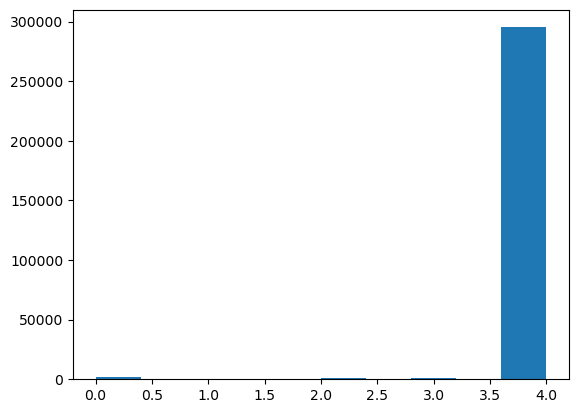

In [239]:
plt.hist(atl03_yapc.atl03_cnf)

In [53]:
titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
xlab = 'S-N latitude'
ylab = 'Height above geoid (m)'
yl = [-5, 60]

mean geoid height -54.41877746582031 m


FileNotFoundError: [Errno 2] No such file or directory: '../figs/cook_east/yapc/cook_east_cyc16_rgt1259-1l_res10.0_yapc.png'

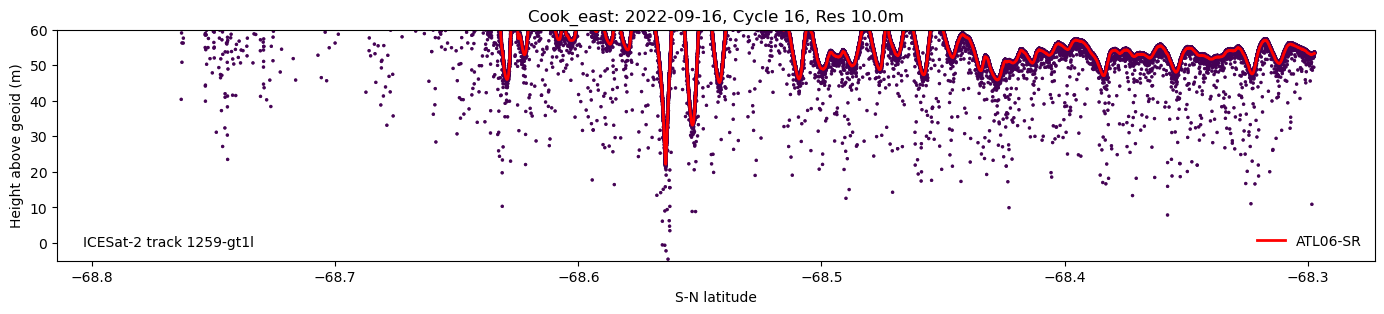

In [54]:
fig, ax = plt.subplots(figsize=[17, 3])
avgGC = np.mean(atl03_yapc.geoid)
print(f'mean geoid height {avgGC} m')
x = atl03_yapc['geometry'].y
y = atl03_yapc.height-avgGC
c = atl03_yapc.yapc_score
plt.scatter(x, y, c=c, s=2, alpha=0.8)#, label='ATL03-YAPC')
x = track['geometry'].y
y = track.h_mean
if not isSeaward:
    print("Track should be reversed to seaward orientation")
    #x = (track['distance']-(track['distance'][-1]))/1000
ax.plot(x, y, '-', color='red', linewidth=2, label='ATL06-SR')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.ylim(yl)
#plt.xlim([-1, 14])
ax.legend(loc=4, frameon=False)
info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
#plt.colorbar()
plt.savefig(f'{figPath}yapc/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_yapc.png', dpi=150, bbox_inches='tight')

In [32]:
badTracks = [(16, 1371, 'gt2l')]

pytmd, a few meters

mean dynamic topography, 1.5 m

advection

REMA strips s79 w168 and s27 w169

In [412]:
np.mean([xl])

-68.625

In [416]:
first = track[np.round(track.geometry.y, 2)==xl[0]].iloc[0].geometry
last = track[np.round(track.geometry.y, 2)==xl[1]].iloc[0].geometry

In [422]:
(np.round(np.mean([first.y, last.y]), 2), np.round(np.mean([first.x, last.x]), 2))

(-68.63, 152.58)

In [407]:
titl = 'ICESat-2 data over Cook Ice Shelf rifts'
xlab = ''
ylab = 'elevation (m)'
xl=[-68.66, -68.59]
yl = [-9, 90]

mean geoid height -54.46400833129883 m


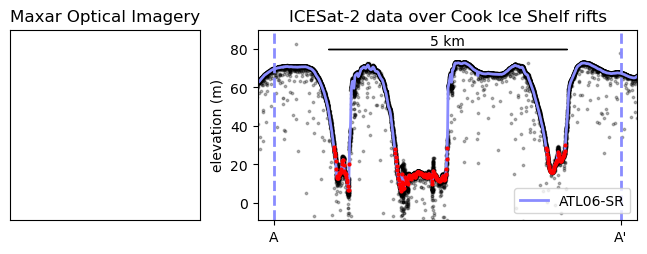

In [410]:
fig, (ax0, ax)  = plt.subplots(1, 2, figsize=[7, 2.5], width_ratios=[1, 2])
fig.tight_layout()

ax0.set_yticks([])
ax0.set_xticks([])
ax0.set_title('Maxar Optical Imagery')

# ICESat-2 data
avgGC = np.mean(atl03_yapc.geoid)
print(f'mean geoid height {avgGC} m')
x = atl03_yapc['geometry'].y
y = atl03_yapc.height-avgGC
ax.scatter(x, y, marker='o', color='black', s=3, alpha=0.15)#, label='ATL03-YAPC')
x = track['geometry'].y
y = track.h_mean
if not isSeaward:
    print("Track should be reversed to seaward orientation")
    #x = (track['distance']-(track['distance'][-1]))/1000
ax.plot(x, y, '-', color='#8a8cff', linewidth=2, label='ATL06-SR')
#ax.plot(x, y, '-', color='#ffb58a', linewidth=2, label='ATL06-SR')

#x = (mTrack['distance']-track['distance'][0])/1000
x = mTrack.geometry.y
y = mTrack.h_mean
ax.plot(x, y, 'o', color='red', markersize=2)#, label='ATL06-SR mélange')
ax.set_title(titl)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_ylim(yl)
ax.set_xlim(xl)
#ax.set_xticks([])
ax.xaxis.set_ticks([-68.657, -68.593])
ax.xaxis.set_ticklabels(['A', 'A\''])
ax.legend(loc=4, frameon=True)
info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
#plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
#         transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

# make length bar
# first point which is approximately equal to x limits (lat limits)
# distance in EPSG:3031, maybe not super accurate
first = track[np.round(track.geometry.y, 2)==xl[0]].to_crs('EPSG:3031').iloc[0].geometry
last = track[np.round(track.geometry.y, 2)==xl[1]].to_crs('EPSG:3031').iloc[0].geometry
distance = first.distance(last)
lengths_scalebar = np.array([0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 500, 1000])
ratios = lengths_scalebar / (0.9* distance/1000)
lengths_scalebar = lengths_scalebar[ratios < 1]
length_scalebar = lengths_scalebar[-1]
xl = ax.get_xlim()
yl = ax.get_ylim()
mid_lat = np.mean(xl)
len_lat = (xl[1]-xl[0]) * (length_scalebar / distance*1000)
h_scale = yl[0] + 0.90 * (yl[1]-yl[0])

ax.axvline(x=-68.657, color='#8a8cff', linestyle='--', linewidth=2)
ax.axvline(x=-68.593, color='#8a8cff', linestyle='--', linewidth=2)

ax.arrow(mid_lat-0.5*len_lat,h_scale,len_lat,0,#head_width=3, head_length=5, 
         fc='k', ec='k',lw=1,ls='-',length_includes_head=True,snap=True)
ax.text(mid_lat, h_scale, '%.10g km' % (length_scalebar),va='bottom',ha='center')

#plt.savefig(f'{figPath}yapc/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_yapc.png', dpi=150, bbox_inches='tight')
plt.savefig(f'/Users/ccroberts/Desktop/Cook_maxar.pdf', dpi=150, bbox_inches='tight')

